In [35]:
from copy import deepcopy

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
from mpl_toolkits import mplot3d
from matplotlib import gridspec
from PIL import Image
import io

from tqdm import tqdm # .notebook
import numpy as np
import requests
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import random_split
import pandas as pd

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, PrecisionRecallDisplay
from torch.utils.tensorboard import SummaryWriter

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
device = torch.device("cpu")

In [193]:
def train_on_batch(model, x_batch, y_batch, optimizer, loss_function):
    model.train()
    model.zero_grad()
    
    output = model(x_batch.to(device))
    
    loss = loss_function(output, y_batch.to(device).squeeze().type(torch.LongTensor))
    loss.backward()

    optimizer.step()
    return loss.cpu().item()

In [194]:
def train_epoch(train_generator, model, loss_function, optimizer, callback = None):
    epoch_loss = 0
    total = 0
    for it, (batch_of_x, batch_of_y) in enumerate(train_generator):
        batch_loss = train_on_batch(model, batch_of_x.to(device), batch_of_y.to(device), optimizer, loss_function)
        
        if callback is not None:
            callback(model, batch_loss)
            
        epoch_loss += batch_loss*len(batch_of_x)
        total += len(batch_of_x)
    
    return epoch_loss/total

In [195]:
def trainer(count_of_epoch, 
            batch_size, 
            dataset,
            model, 
            loss_function,
            optimizer,
            lr = 0.001,
            callback = None):

    optima = optimizer(model.parameters(), lr=lr)
    
    iterations = tqdm(range(count_of_epoch), desc='epoch')
    iterations.set_postfix({'train epoch loss': np.nan})
    for it in iterations:
        batch_generator = tqdm(
            torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True), 
            leave=False, total=len(dataset)//batch_size+(len(dataset)%batch_size> 0))
        
        epoch_loss = train_epoch(train_generator=batch_generator, 
                    model=model, 
                    loss_function=loss_function, 
                    optimizer=optima, 
                    callback=callback)
        
        iterations.set_postfix({'train epoch loss': epoch_loss})

In [196]:
class callback():
    def __init__(self, writer, dataset, loss_function, delimeter = 100, batch_size=64):
        self.step = 0
        self.writer = writer
        self.delimeter = delimeter
        self.loss_function = loss_function
        self.batch_size = batch_size

        self.dataset = dataset

    def forward(self, model, loss):
        self.step += 1
        self.writer.add_scalar('LOSS/train', loss, self.step)
        
        if self.step % self.delimeter == 0:
            
            self.writer.add_graph(model, self.dataset[0][0].view(1,1,28,28).to(model.device))
            
            batch_generator = torch.utils.data.DataLoader(dataset = self.dataset, 
                                                          batch_size=self.batch_size)
            
            pred = []
            real = []
            test_loss = 0
            for it, (x_batch, y_batch) in enumerate(batch_generator):
                x_batch = x_batch.to(model.device)
                y_batch = y_batch.to(model.device)

                output = model(x_batch)

                test_loss += self.loss_function(output, y_batch).cpu().item()*len(x_batch)

                pred.extend(torch.argmax(output, dim=-1).cpu().numpy().tolist())
                real.extend(y_batch.cpu().numpy().tolist())
            
            test_loss /= len(self.dataset)
            
            self.writer.add_scalar('LOSS/test', test_loss, self.step)

            self.writer.add_text('REPORT/test', str(classification_report(real, pred)), self.step)
          
    def __call__(self, model, loss):
        return self.forward(model, loss)

In [197]:
df = pd.read_csv('data_seeds.csv')
df

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove
0,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,14.99,0.9034,5.658,3.562,1.355,5.175,1
...,...,...,...,...,...,...,...
205,13.20,0.8783,5.137,2.981,3.631,4.870,3
206,12.88,0.8511,5.140,2.795,4.325,5.003,3
207,13.66,0.8883,5.236,3.232,8.315,5.056,3
208,13.21,0.8521,5.175,2.836,3.598,5.044,3


In [207]:
data_columns = df.columns[:-1]
labels = df.columns[-1]

X = df[data_columns]
y = df[[labels]]
#y = (df[[labels]] == 1).astype(int)

X = torch.Tensor(X.to_numpy())
y = torch.Tensor(y.to_numpy()) - 1

dataset = TensorDataset(X, y)

generator = torch.Generator().manual_seed(42)
train_ds, val_ds, test_ds = random_split(dataset, [0.7, 0.1, 0.2], generator=generator)

In [208]:
BATCH_SIZE = 64

In [209]:
class myNN(torch.nn.Module):
    @property
    def device(self):
        for p in self.parameters():
            return p.device
        
    def __init__(self):
        super(myNN, self).__init__()
        
        self.layers = torch.nn.Sequential()
        self.layers.add_module('linear1', torch.nn.Linear(6, 7))
        self.layers.add_module('relu1', torch.nn.ReLU())
        self.layers.add_module('linear2', torch.nn.Linear(7, 7))
        self.layers.add_module('relu2', torch.nn.ReLU())
        self.layers.add_module('linear3', torch.nn.Linear(7, 3))
        #self.layers.add_module('softmax', torch.nn.Softmax(dim=-1))

    def forward(self, input):
        x = self.layers(input)
        x = torch.argmax(x, dim=1)
        return x 

In [210]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = torch.nn.Linear(6, 7)
        self.fc2 = torch.nn.Linear(7, 7)
        self.fc3 = torch.nn.Linear(7, 3)
    def forward(self, x):
        x = x.view(-1, 6)
        x = torch.functional.F.relu(self.fc1(x))
        x = torch.functional.F.relu(self.fc2(x))
        #x = self.fc3(x)
        #x = torch.functional.F.sigmoid(self.fc3(x))
        x = torch.functional.F.softmax(self.fc3(x), dim=1)
        return x 

In [211]:
y_train = torch.randint(0, 3, (100,))

In [212]:
m = torch.nn.Softmax(dim=1)
input = torch.randn(2, 3)
output = m(input)
torch.argmax(output, dim=1)

tensor([2, 0])

In [213]:
output

tensor([[0.1749, 0.1092, 0.7159],
        [0.3721, 0.3278, 0.3002]])

In [214]:
#loss_function = torch.nn.BCELoss()
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam

call = callback(None, val_ds, loss_function, delimeter = 10)

# model = myNN()
model = Net()
model.to(device)

Net(
  (fc1): Linear(in_features=6, out_features=7, bias=True)
  (fc2): Linear(in_features=7, out_features=7, bias=True)
  (fc3): Linear(in_features=7, out_features=3, bias=True)
)

In [215]:
trainer(count_of_epoch = 200,
        batch_size = BATCH_SIZE,
        dataset = train_ds,
        model = model,
        loss_function = loss_function,
        optimizer = optimizer,
        lr = 0.001,)
        #callback = call)

epoch: 100%|██████████| 200/200 [00:04<00:00, 45.30it/s, train epoch loss=0.955]


In [81]:
model.eval()

Net(
  (fc1): Linear(in_features=6, out_features=7, bias=True)
  (fc2): Linear(in_features=7, out_features=7, bias=True)
  (fc3): Linear(in_features=7, out_features=1, bias=True)
)

In [ ]:
batch_generator = torch.utils.data.DataLoader(dataset = test_ds, 
                                              batch_size=64)
            
pred = []
real = []
test_loss = 0
with torch.no_grad():
    for it, (x_batch, y_batch) in enumerate(batch_generator):
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        output = model(x_batch)

        test_loss += loss_function(output, y_batch).cpu().item()*len(x_batch)

        pred.extend(output.cpu().numpy().tolist())
        real.extend(y_batch.cpu().numpy().tolist())

    test_loss /= len(test_ds)

    print('Loss: {}'.format(test_loss))

In [218]:
torch.argmax(model(X), dim=1)

tensor([0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 2, 0, 2, 1, 1, 2, 2, 0, 0, 2, 1, 1, 0, 0,
        0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 2, 1, 1, 1, 2, 1, 0, 0, 1,
        1, 0, 1, 2, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 2, 0, 1, 0, 0, 0, 1, 1, 2,
        1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 2, 0, 1, 0, 0, 1, 2, 1, 0, 1, 1, 2, 2, 1,
        1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 2, 1, 0, 1, 1, 1, 1,
        2, 1, 1, 1, 1, 1, 1, 0, 0, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1,
        2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2])

In [219]:
print(classification_report(y, torch.argmax(model(X), dim=1), digits=3))

              precision    recall  f1-score   support

         0.0      0.651     0.400     0.496        70
         1.0      0.483     0.600     0.535        70
         2.0      0.713     0.814     0.760        70

    accuracy                          0.605       210
   macro avg      0.615     0.605     0.597       210
weighted avg      0.615     0.605     0.597       210



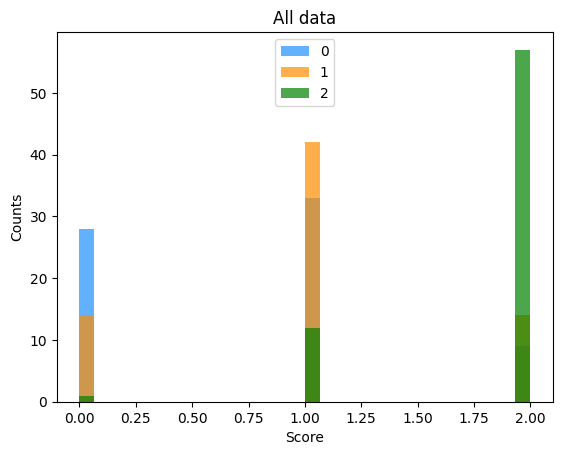

In [222]:
A = np.array(torch.argmax(model(X), dim=1))
B = y
class_0 = np.array([A[i] for i in range(len(A)) if B[i] == 0])
class_1 = np.array([A[i] for i in range(len(A)) if B[i] == 1])
class_2 = np.array([A[i] for i in range(len(A)) if B[i] == 2])
plt.hist(class_0, alpha=0.7, label='0', color="dodgerblue", bins=30)
plt.hist(class_1, alpha=0.7, label='1', color='darkorange', bins=30)
plt.hist(class_2, alpha=0.7, label='2', color='green', bins=30)
plt.xlabel('Score')
plt.ylabel('Counts')
plt.title('All data')
plt.legend(loc='upper center')
plt.show()